In [2]:
import pandas as pd

import _background as bg
import molNet
from molNet.dataloader.molecule_loader import PytorchGeomMolDfLoader
from molNet.featurizer.atom_featurizer import atom_formal_charge, atom_partial_charge, atom_hybridization_one_hot, \
    atom_is_aromatic, atom_is_in_ring, atom_symbol_one_hot_from_set
from molNet.featurizer.featurizer import FeaturizerList
import pytorch_lightning as pl
import torch

In [3]:
dataset = pd.read_csv("data/Lipophilicity.csv")

In [4]:
dataset

,CMPD_CHEMBLID,exp,smiles
0,CHEMBL596271,3.54,Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14
1,CHEMBL1951080,-1.18,COc1cc(OC)c(cc1NC(=O)CSCC(=O)O)S(=O)(=O)N2C(C)...
2,CHEMBL1771,3.69,COC(=O)[C@@H](N1CCc2sccc2C1)c3ccccc3Cl
3,CHEMBL234951,3.37,OC[C@H](O)CN1C(=O)C(Cc2ccccc12)NC(=O)c3cc4cc(C...
4,CHEMBL565079,3.10,Cc1cccc(C[C@H](NC(=O)c2cc(nn2C)C(C)(C)C)C(=O)N...
...,...,...,...
4195,CHEMBL496929,3.85,OCCc1ccc(NC(=O)c2cc3cc(Cl)ccc3[nH]2)cc1
4196,CHEMBL199147,3.21,CCN(C1CCN(CCC(c2ccc(F)cc2)c3ccc(F)cc3)CC1)C(=O...
4197,CHEMBL15932,2.10,COc1cccc2[nH]ncc12
4198,CHEMBL558748,2.65,Clc1ccc2ncccc2c1C(=O)NCC3CCCCC3


In [5]:
dataset["rd_mol"]=dataset["smiles"].apply(bg.MolFromSmiles)
c_mp_atom_symbol_featurizer = atom_symbol_one_hot_from_set(dataset["rd_mol"],only_mass=True)


featurizer = FeaturizerList([
    c_mp_atom_symbol_featurizer,
    atom_formal_charge,
    atom_partial_charge,
    atom_hybridization_one_hot,
    atom_is_in_ring,
    atom_is_aromatic,
])

In [6]:
loader_LipopModel1 = PytorchGeomMolDfLoader(dataset,
                                         y_columns=["exp"],
                                         columns=[],
                                         atom_featurizer=featurizer,
                                         inplace=True,
                                         seed=1,
                                         batch_size=128,
                                         to_graph_input_kwargs=dict(
                                             with_mol_graph=True
                                         ),
                                         )


In [7]:
loader_LipopModel1.setup()
for d in loader_LipopModel1.test_dataloader():
    print(d)
    break

Batch(batch=[6146], edge_index=[2, 12896], mol_graph=[128], x=[6146, 25], x_graph_features=[128, 0], y=[6146, 0], y_graph_features=[128, 1])


In [8]:
class LipopModel1(pl.LightningModule):
    def __init__(self,in_size,out_size,name="none",n_chem_layer=6,chem_layer_feats_out=40,chem_layer_gc_out=30,chem_layer_net_sizes=10,chem_layer_net_count=2,
                 collector_net_depth=3,collector_net_depth_red_fac=2,lr=1e-3,poolings=["pool_wsum"]):
        super().__init__()
        self.save_hyperparameters()
        
        #print(self.hparams)
        
        chem_layer=[
            bg.ChemGCLayer(in_size,[chem_layer_net_sizes if chem_layer_net_sizes >=0 else in_size]*chem_layer_net_count,chem_layer_gc_out,chem_layer_feats_out,bias=False,linear_activation=torch.nn.ELU(),concat_input=True)
        ]
        for n in range(n_chem_layer-1):
            chem_layer.append(bg.ChemGCLayer(chem_layer[-1].feats_out,[chem_layer_net_sizes if chem_layer_net_sizes >=0 else chem_layer[-1].feats_out]*chem_layer_net_count,chem_layer_gc_out,chem_layer_feats_out,bias=False,linear_activation=torch.nn.ELU(),concat_input=True))
        
        self.chem_layer=torch.nn.Sequential(*chem_layer)
        
        
        self.lr = lr
        
        poolings_layer=[]
        for p in poolings:
            if p=="pool_max":
                poolings_layer.append(molNet.nn.models.graph_convolution.PoolMax())
            elif p=="pool_min":
                poolings_layer.append(molNet.nn.models.graph_convolution.PoolMin())
            elif p=="pool_mean":
                poolings_layer.append(molNet.nn.models.graph_convolution.PoolMean())
            elif p=="pool_sum":
                poolings_layer.append(molNet.nn.models.graph_convolution.PoolSum())
            elif p=="pool_wsum":
                poolings_layer.append(molNet.nn.models.graph_convolution.PoolWeightedSum(self.chem_layer[-1].feats_out,normalize=False))
            elif p=="pool_nwsum":
                poolings_layer.append(molNet.nn.models.graph_convolution.PoolWeightedSum(self.chem_layer[-1].feats_out,normalize=True))

            else:
                raise Exception("unknown pooling '{}'".format(p))
        
        self.pooling=molNet.nn.models.graph_convolution.MergedPooling(
            {"pool_{}".format(i):poolings_layer[i] for i in range(len(poolings_layer))}
        )
        
        #self.post_pool_norm=torch.nn.Sigmoid()
        
        collector_net = [
            torch.nn.Linear(len(self.pooling)*self.chem_layer[-1].feats_out,max(1,int(len(self.pooling)*self.chem_layer[-1].feats_out/collector_net_depth_red_fac))),
            torch.nn.ReLU()
        ]
        
        for i in range(collector_net_depth-1):
            collector_net.append(torch.nn.Linear(collector_net[-2].out_features,max(1,int(collector_net[-2].out_features/collector_net_depth_red_fac))))
            collector_net.append(torch.nn.ReLU())
        collector_net.append(torch.nn.Linear(collector_net[-2].out_features,out_size))
        
        #collector_net.append(torch.nn.Sigmoid())
        self.nn=torch.nn.Sequential(*collector_net)
        
        
        
        self.lossf=torch.nn.MSELoss()#torch.nn.BCELoss()#

    def unpacked_forward(self, feats, edges, batch,graph_features):
        feats,_,_ = self.chem_layer((feats, edges, batch))

        y_hat = self.pooling(feats,batch)
        #y_hat = self.post_pool_norm(y_hat)
        y_hat = self.nn(y_hat)
        return y_hat
      
    def forward(self,batch):
        return self.unpacked_forward(feats=batch.x,edges=batch.edge_index,batch=batch.batch,graph_features=batch.x_graph_features)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

    def batch_to_loss(self,batch):
        y_hat=self(batch)
        loss = self.lossf(y_hat, batch.y_graph_features)
        return loss

    def training_step(self,batch, *args, **kwargs):
        loss =  self.batch_to_loss(batch)
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self,batch, *args, **kwargs):
        loss =  self.batch_to_loss(batch)
        self.log('val_loss', loss)
        return loss
    
    def test_step(self,batch, *args, **kwargs):
        loss =  self.batch_to_loss(batch)
        self.log('test_loss', loss)
        return loss

model_LipopModel1 = LipopModel1(in_size=len(featurizer),out_size=1)

In [9]:
model_LipopModel1 = LipopModel1(in_size=len(featurizer),
                          out_size=1,
                              n_chem_layer = 6,
                              chem_layer_feats_out=64,
                              chem_layer_gc_out=32,
                              chem_layer_net_sizes=-1,
                              chem_layer_net_count=1,
                              collector_net_depth=5,
                              collector_net_depth_red_fac=2,
                              poolings=["pool_min","pool_max","pool_mean","pool_nwsum"],
                              lr=0.001,
                             )

In [10]:
#model_LipopModel1

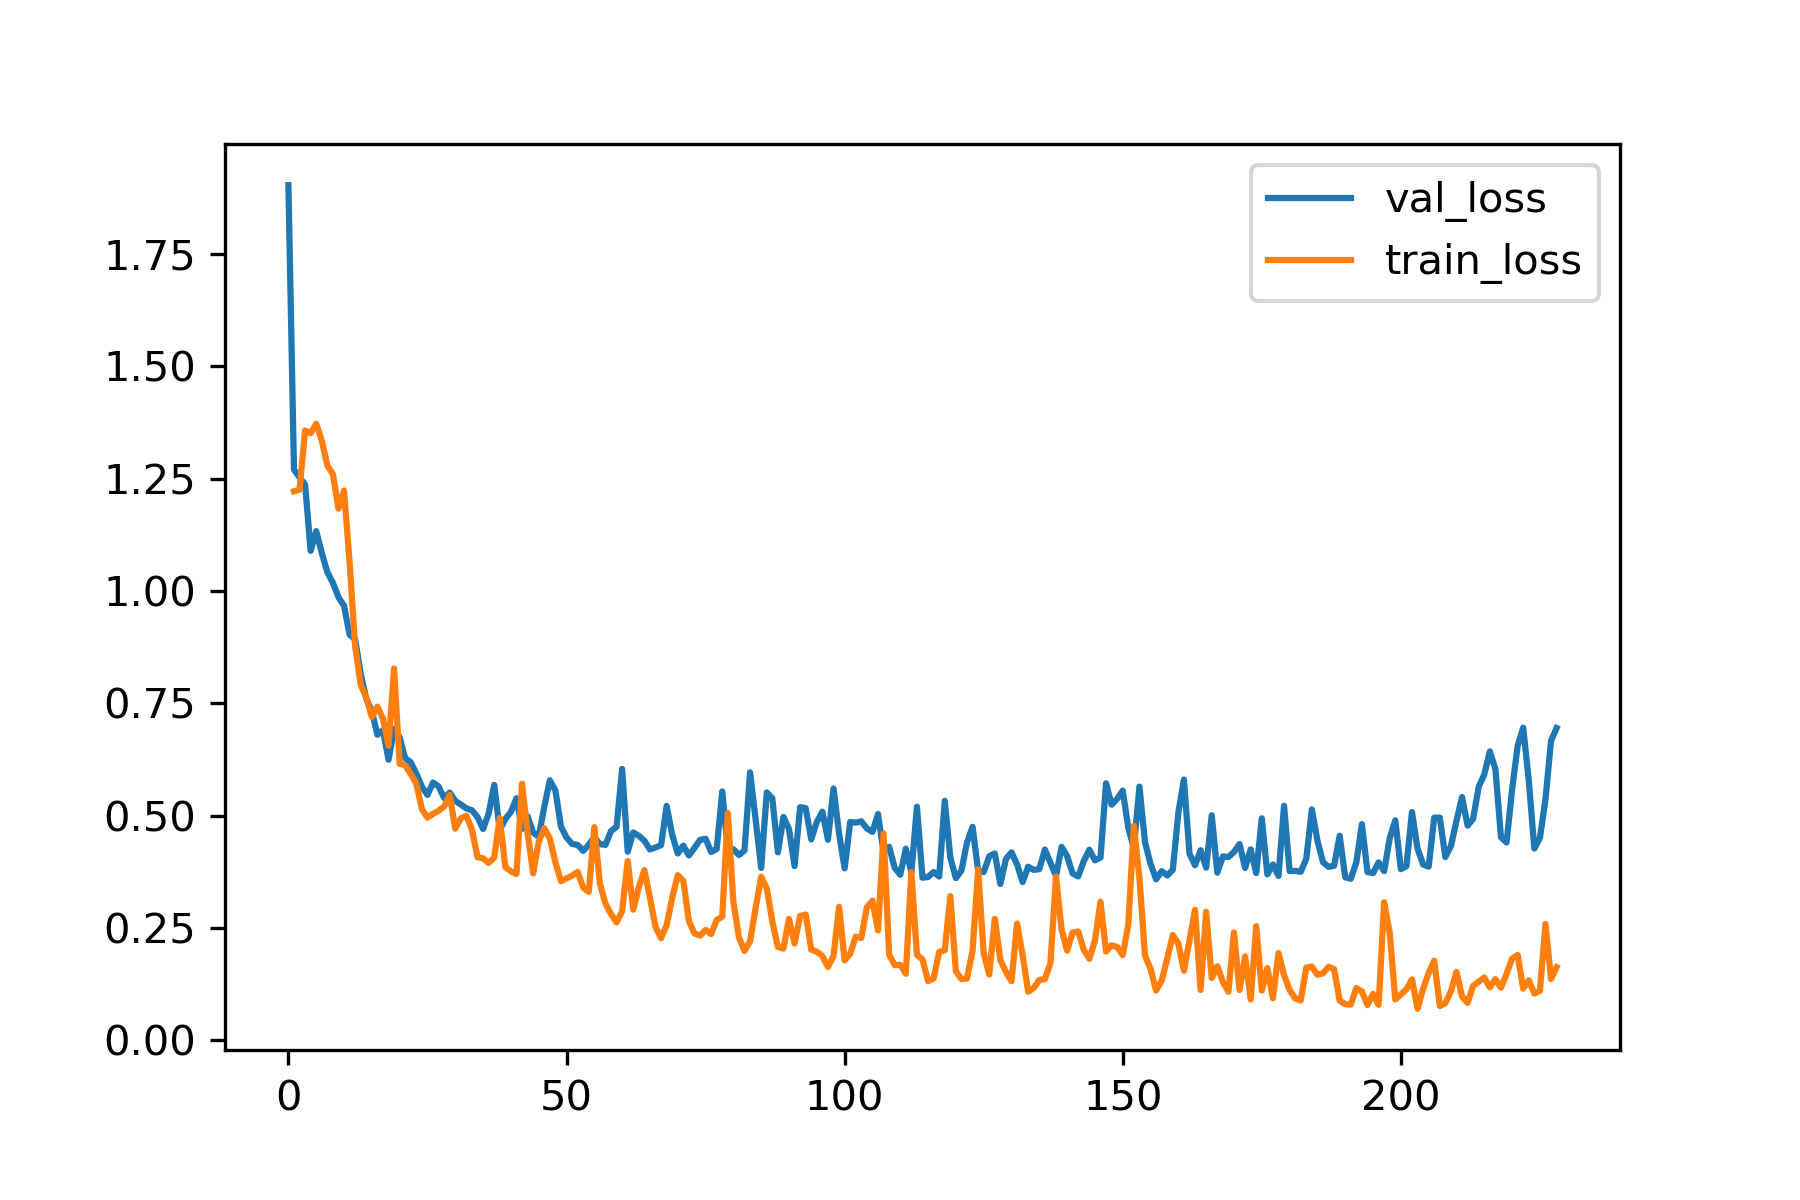

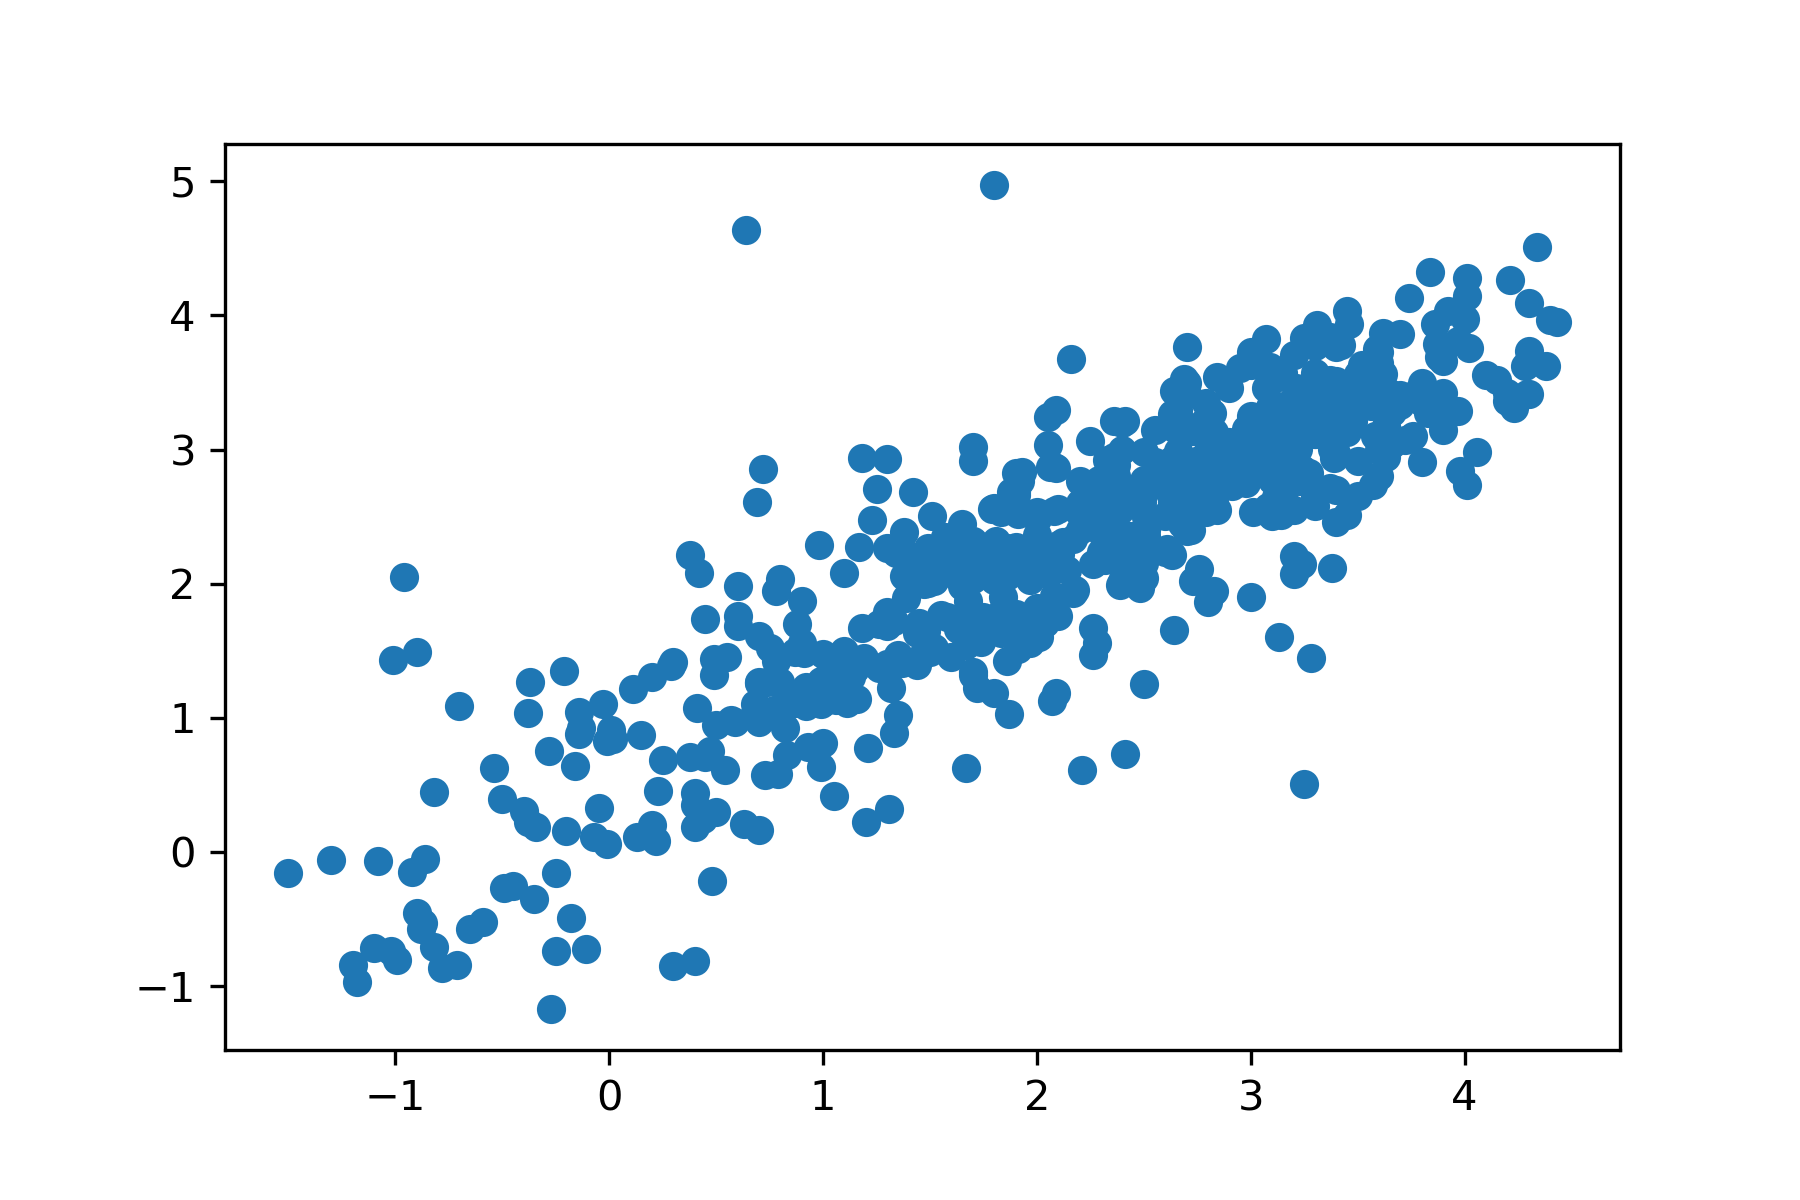

In [11]:
model_LipopModel1,data_LipopModel1 = bg.default_model_run(
        "LipopModel1",
        model_LipopModel1,
        loader_LipopModel1,
                      force_run=False,
                      #force_test_data_reload=True,
                    #min_epochs=200,
                    early_stopping=True,
                    max_epochs=1000,
                    early_stopping_delta=0,
                   detect_lr=False,
                    early_stop_patience=100,
    )

In [12]:
import numpy as np
#list(model_FGModel1.parameters())
model_parameters = filter(lambda p: p.requires_grad, model_LipopModel1.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
params

2215700

In [13]:
true=[]
pred=[]
try:
    loader_LipopModel1.train_dataloader()
except:
    loader_LipopModel1.setup()
    
for l in [
        loader_LipopModel1.train_dataloader(),
          loader_LipopModel1.val_dataloader(),
          loader_LipopModel1.test_dataloader()
         ]:
    for d in l:
        pred.extend(model_LipopModel1(d).detach().flatten().numpy().tolist())
        true.extend(d.y_graph_features.flatten().numpy().tolist())
        
    #print(()-np.exp(d.y.numpy())).mean())

pred=np.array(pred)
true=np.array(true)


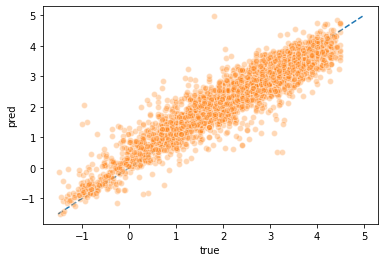

In [14]:
import matplotlib.pyplot as plt

dmin=min(true.min(),pred.min())
dmax=max(true.max(),pred.max())

plt.plot([dmin,dmax],[dmin,dmax],"--")
plt.plot(true,pred,"o",alpha=0.3,markeredgecolor="w")
plt.xlabel("true")
plt.ylabel("pred")
plt.show()
plt.close()
#plt.plot(np.exp(pred),np.exp(true),"o")
#plt.show()
#plt.close()

In [19]:
#print(np.abs(np.exp(pred)-np.exp(true)).mean())
np.sqrt((np.abs(pred-true)**2).mean()),np.abs(pred-true).mean()

(0.4423174167271108, 0.3205347439235387)

In [78]:
model_LipopModel1

LipopModel1(
  (chem_layer): Sequential(
    (0): ChemGCLayer(
      (fcnn): Sequential(
        (0): Linear(in_features=25, out_features=10, bias=False)
      )
      (gc): GCNConv(10, 32)
      (combine): Sequential(
        (0): Linear(in_features=42, out_features=64, bias=False)
      )
    )
    (1): ChemGCLayer(
      (fcnn): Sequential(
        (0): Linear(in_features=64, out_features=10, bias=False)
      )
      (gc): GCNConv(10, 32)
      (combine): Sequential(
        (0): Linear(in_features=42, out_features=64, bias=False)
      )
    )
    (2): ChemGCLayer(
      (fcnn): Sequential(
        (0): Linear(in_features=64, out_features=10, bias=False)
      )
      (gc): GCNConv(10, 32)
      (combine): Sequential(
        (0): Linear(in_features=42, out_features=64, bias=False)
      )
    )
    (3): ChemGCLayer(
      (fcnn): Sequential(
        (0): Linear(in_features=64, out_features=10, bias=False)
      )
      (gc): GCNConv(10, 32)
      (combine): Sequential(
        (0

In [30]:
import numpy as np
ysa=np.array(ys)